# <center>Total MDA: A Python-based Tool for Calculating and Evaluating MDAs from Detrital Geo-Thermochronologic Data<center>


## <center>Morgan D. Brooks</center>

### <center>Version 1.0.0</center>

# Load Modules and Data

### 1. Import Required Modules

First, execute the following by selecting the cell below and pressing return+shift. Note: select a cell and press return+shift to execute all future code 

In [81]:
import MDA_Functions as MDAFunc
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import math 
import peakutils

### 2. Download Excel File to Input Data & Load Data to Notebook

This is where you will load your excel file of data. This step must by run initially, and should be repeated if any changes are made to the dataset in Excel. This step will load data from a CSV into a DataFrame; into a variable called df. 

1. Open the excel file in the MDA_Tool Directory (same loaction as this Jupyter file) titled: "Data_Upload"
2. Opent the excel file and fill in 2 Sheets titled: "Samples" and "Data"
3. For the "Samples" sheet: you MUST fill in the Sample_ID column with all the individual samples, but the "Unit" and "Basin" columns can be left blank
4. The "Data" sheet must have the following columns filled in: 
    - Sample_ID
    - BestAge (this age will be used for calculating all MDAs) 
    - BestAge_err_sx (can be 1sigma or 2sigma)
    - At least one ratio and error: 207/206, 206/208, or 207/235 
    - The remaining columns can be left blank 
5. Save the file as a .csv and close it 
4. Press return+shift in the cell below to load your data

In [29]:
###############################################################
# Functions for loading a dataset and selecting samples 
###############################################################

def loadData(samples_df, analyses_df, ID_col = 'Sample_ID'):
    """
    Creates a Pandas DataFrame from DataFrames of samples and analyses
    
    Parameters
    ----------
    samples : A Pandas DataFrame that contains sample information.
    analyses : A Pandas DataFrame that contains analysis information.
    ID_col : (optional) The name of the column that contains unique sample identifiers. Default is 'Sample_ID'
    
    Returns
    -------
    main_byid_df : A Pandas DataFrame indexed by Sample_ID
    
    Notes
    -----
    Portions of this script were provided by Kevin Befus (University of Wyoming)

    """
    main_byid_df = None
    analyses_df.set_index('Sample_ID',inplace=True,drop=False)
    samples_df.set_index('Sample_ID',inplace=True,drop=False)
    main_byid_df = samples_df.copy() # Samples table is the starting point

    for sample in main_byid_df[ID_col]: # loop through entries in main_df
        if sample in analyses_df[ID_col]: # Allows samples to exist without analyses data
            active_UPb_data = analyses_df.loc[analyses_df[ID_col].isin([sample]),:]
            for colname in active_UPb_data:
                if colname not in [ID_col]: # Skip if the indexing column
                    # Check column naming overlap with the Samples table (having the same column name will otherwise result in an error)
                    if colname in samples_df.columns:
                        colname_adj = colname+'_data' # New name for colname
                        if colname_adj not in main_byid_df.columns: # Make colname with revised name if already in samples table
                            main_byid_df[colname_adj] = (np.nan*np.empty(shape=(len(main_byid_df),1))).tolist()
                            main_byid_df[colname_adj] = np.asarray(main_byid_df[colname_adj])                
                        main_byid_df.at[sample,colname_adj] = active_UPb_data[colname].values
                    else:
                        if colname not in main_byid_df.columns: # Make colname with revised name if already in samples table
                            main_byid_df[colname] = (np.nan*np.empty(shape=(len(main_byid_df),1))).tolist()
                            main_byid_df[colname] = np.asarray(main_byid_df[colname])
                        main_byid_df.at[sample,colname] = active_UPb_data[colname].values
        else:
            for colname in analyses_df.columns:
                if colname not in [ID_col]:
                    if colname in samples_df.columns:
                        colname_adj = colname+'_data' # New name for colname
                        if colname_adj not in main_byid_df.columns: # Make colname with revised name if already in samples table
                            main_byid_df[colname_adj] = (np.nan*np.empty(shape=(len(main_byid_df),1))).tolist()
                            main_byid_df[colname_adj] = np.asarray(main_byid_df[colname_adj])                
                        main_byid_df.at[sample,colname_adj] = []
                    else:
                        if colname not in main_byid_df.columns: # Make colname with revised name if already in samples table
                            main_byid_df[colname] = (np.nan*np.empty(shape=(len(main_byid_df),1))).tolist()
                            main_byid_df[colname] = np.asarray(main_byid_df[colname])
                        main_byid_df.at[sample,colname] = []       
    return main_byid_df

def loadDataExcel(dataToPlot, mainSheet = 'Samples', dataSheet = 'Data', ID_col = 'Sample_ID'):
    """
    Loads an Excel file containing detrital geochronologic and/or thermochronologic data
    
    Parameters
    ----------
    dataToPlot : An array with the full filePath of each data file to be loaded, including the directory, file name, and extension
    mainSheet : (optional) The name of the Excel worksheet that contains sample information. The default name is 'Samples'
    dataSheet : (optional) The name of the Excel worksheet that contains grain analysis information. The default name is 'ZrUPb'
    ID_col : (optional) The name of the column that contains unique sample identifiers. Default is 'Sample_ID'

    Returns
    -------
    main_df : the database
    main_byid_df : the database indexed by sample name
    
    Notes
    -----
    Portions of this script were provided by Kevin Befus (University of Wyoming)
    """    
    
    obj1 = []
    obj2 = []
    obj3 = []
    obj4 = []
    for i in range(len(dataToPlot)):
        dfs = pd.read_excel(dataToPlot[i],sheet_name=None)
        main_df = None
        main_df = dfs[mainSheet]
        samples_df = main_df.copy()
        analyses_df = dfs[dataSheet]
    
        for sample_ind in range(main_df.shape[0]): # loop through entries in main_df
            active_sample_id = main_df.loc[sample_ind,ID_col]
            active_UPb_data = dfs[dataSheet].loc[dfs[dataSheet][ID_col].isin([active_sample_id]),:]
            for colname in active_UPb_data:
                if colname not in [ID_col]: # Skip if the indexing column
                    # Check column naming overlap with the Samples table (having the same column name will otherwise result in an error)
                    if colname in samples_df.columns:
                        colname_adj = colname+'_'+dataSheet # New name for colname
                        if colname_adj not in main_df.columns: # Make colname with revised name if already in samples table
                            main_df[colname_adj] = (np.nan*np.empty(shape=(len(main_df),1))).tolist()
                            main_df[colname_adj] = np.asarray(main_df[colname_adj])                
                        main_df.at[sample_ind,colname_adj] = active_UPb_data[colname].values
                    else:
                        if colname not in main_df.columns: # Make colname with revised name if already in samples table
                            main_df[colname] = (np.nan*np.empty(shape=(len(main_df),1))).tolist()
                            main_df[colname] = np.asarray(main_df[colname])
                        main_df.at[sample_ind,colname] = active_UPb_data[colname].values
    
        # Make a copy of the dataset and set the sample ID as index
        main_byid_df = main_df.copy()
        main_byid_df.set_index(ID_col,inplace=True,drop=False)
        obj1.append(main_df)
        obj2.append(main_byid_df)
        obj3.append(samples_df)
        obj4.append(analyses_df)
    main_df = pd.concat(obj1, sort=False)
    main_byid_df = pd.concat(obj2, sort=False)
    samples_df = pd.concat(obj3, sort=False)
    analyses_df = pd.concat(obj4, sort=False)
    
    return main_df, main_byid_df, samples_df, analyses_df


In [154]:
# Specify file paths to data input file(s)
dataToLoad = ['Data/Data_Upload_1.xlsx',
              'Data/Data_Upload_2.xlsx']

main_df, main_byid_df, samples_df, analyses_df = loadDataExcel(dataToLoad)

main_byid_df.head(15)

,Sample_ID,Unit,Basin,207Pb/206Pb,207Pb/206Pb err,206Pb/238U,206Pb/238U err,207Pb/235Pb,207Pb/235Pb err,75Age,...,68Age,68Age_err,76Age,76Age_err,BestAge,BestAge_err_sx,BestAge_err_stotal,U_ppm,U_Th,Th_U
Sample_ID,,,,,,,,,,,,,,,,,,,,,
POR-2,POR-2,Point of Rocks Ss,San Joaquin basin,"[0.0406881889456608, 0.04602798541712321, 0.04...","[0.005552522773590929, 0.007519798305100781, 0...","[0.006687861050854221, 0.0072719567694101645, ...","[0.00012506301931104475, 0.0001018074277218713...","[0.037519485628478996, 0.04615030015640152, 0....","[0.005167952957787695, 0.007567414000591077, 0...","[37.39935449561242, 45.81108363542066, 47.6174...",...,"[42.96919594561263, 46.708419534945264, 48.226...","[0.800852038337176, 0.6515547700251538, 0.9993...","[-307.07890707133015, -0.8928101005134416, 17....","[350.5904941293329, 396.0820325790396, 41.2019...","[42.96919594561263, 46.708419534945264, 48.226...","[0.800852038337176, 0.6515547700251538, 0.9993...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.627621449689062, 0.4961071900646707, 0.0520..."
POR-3,POR-3,Point of Rocks Ss,San Joaquin basin,"[0.04670790060262111, 0.047672351283777774, 0....","[0.011743393592522144, 0.008033745500213678, 0...","[0.007026652857469043, 0.013299217102483786, 0...","[0.0010746806645855179, 0.000494826248668319, ...","[0.045252244022150404, 0.08741660243827779, 0....","[0.013317138402255946, 0.015086234083045016, 0...","[44.93906496242438, 85.09396723053692, 89.2389...",...,"[45.13831407280074, 85.16718033964855, 86.8715...","[6.8794994529228966, 3.1479894061072287, 1.769...","[34.3248370021054, 83.01650526932218, 153.0324...","[610.3829868966902, 402.33668293556605, 73.693...","[45.13831407280074, 85.16718033964855, 86.8715...","[6.8794994529228966, 3.1479894061072287, 1.769...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.9837507073194807, 0.2970781234307026, 0.858..."
BUT-5,BUT-5,Butano Ss,La Honda basin,"[0.05762354763728019, 0.03641110633769712, 0.0...","[0.011269888448444877, 0.010694335370449353, 0...","[0.01248059231288972, 0.01259869011900655, 0.0...","[0.0007166957165695656, 0.0008100399909659366,...","[0.09915998766360977, 0.06325000202868346, 0.0...","[0.02021217639564266, 0.019017116096352923, 0....","[96.00065035127058, 62.273703670211894, 85.301...",...,"[79.95714249032814, 80.70902156952796, 82.3027...","[4.563167174061512, 5.156884411054435, 1.38264...","[515.4568924560183, -599.9301958570051, 170.06...","[433.2945978448812, 812.5849145152981, 159.693...","[79.95714249032814, 80.70902156952796, 82.3027...","[4.563167174061512, 5.156884411054435, 1.38264...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.2867765283029227, 0.7227353978942941, 0.733..."
POR-1,POR-1,Point of Rocks Ss,San Joaquin basin,"[0.04806541191382841, 0.042734788224866385, 0....","[0.004940324799540449, 0.013156269746160855, 0...","[0.006760606112963907, 0.012732052609210369, 0...","[0.0001265067265072234, 0.0015769994338613196,...","[0.04480428767161959, 0.07502072473666914, 0.0...","[0.004680830620337464, 0.024894938561114112, 0...","[44.50381616700174, 73.45274937157997, 82.1040...",...,"[43.43500851336782, 81.55797905712907, 84.2409...","[0.8100384095577873, 10.038192931921522, 3.583...","[102.48489961586091, -183.0155274310181, 20.37...","[243.56638391351234, 784.5500500306964, 289.45...","[43.43500851336782, 81.55797905712907, 84.2409...","[0.8100384095577873, 10.038192931921522, 3.583...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2.5070011249322732, 0.6143287549109991, 0.361..."
BUT-4,BUT-4,Butano Ss,La Honda b

### 3. Check That the Data Loaded Properly & Review Unique Samples

Execute the following code to examine the frist 5 rows of your data to make sure it loaded correctly and to view the unique samples that were found in your data:

In [ ]:
MDAFunc.check_data_loading(main_byid_df)

In [35]:

def check_data_loading(df):
    amount_of_samples = df.Sample_ID.nunique()
    sample_array = df["Sample_ID"].unique() 
    sample_list = list(sample_array)
    sample_amounts_table = df.groupby('Sample_ID').BestAge.nunique().reset_index()
    sample_amounts_table.rename(columns={
    'BestAge': 'Sample_Size'},
    inplace=True)
    print('')
    print("The following " + str(amount_of_samples) + " unique samples were found in your data with the following sample size:")
    print('')
    print(sample_amounts_table)
    print('')
    print("Here is a list of your samples to use in the following section:")
    print("")
    print(sample_list)
    return

check_data_loading(analyses_df) 


The following 32 unique samples were found in your data with the following sample size:

       Sample_ID  Sample_Size
0       1-Fosado          116
1    10-Sobrarbe          104
2   11-Escanilla          112
3   12-Escanilla          123
4       13-Guaso          119
5       14AB-A04          108
6       14AB-A05          104
7       14AB-A06          110
8       14AB-F01           93
9       14AB-G07          114
10      14AB-M02          114
11      15AB-118          120
12      15AB-150          120
13      15AB-352          120
14        2-Arro          115
15       3-Gerbe          104
16       4-Ainsa           97
17     5-Morillo          101
18     6-Morillo          112
19       7-Guaso          117
20         BUT-1          100
21         BUT-2           99
22         BUT-3          100
23         BUT-4           99
24         BUT-5           96
25         POR-1          100
26         POR-2           97
27         POR-3          101
28         SEF-1           99
29        

### 4. Select Samples and Error 
Use the above sample list to select the samples you would like to plot and copy them into the cell below and execute the code by selecting the cell and pressing shift+enter. 

The sample list must be in this exact format: with a comma (,) between all samples as follows: sample_list = ['3-Gerbe', '14AB-G07']

Also specify the sx (without systematic) uncertainty of your data as 1sigma or 2sigma below

In [132]:
sample_list = ['POR-2', 'POR-3', 'BUT-5', 'POR-1', 'BUT-4']

sigma = '2sigma'


ages, errors, numGrains, labels = sampleToData(sample_list, main_byid_df, sigma=sigma)

print(ages, errors)

[array([  42.96919595,   46.70841953,   48.22694335,   48.41730172,
         49.10835897,   49.14461675,   49.48530647,   51.22086048,
         54.65589057,   72.05457641,   77.91566017,   80.16965018,
         85.2039234 ,   85.78570527,   86.1921268 ,   88.27203406,
         89.76161245,   90.52889138,   91.12966608,   91.6057935 ,
         92.21959909,   92.74717094,   93.01180351,   93.75134589,
         95.09167072,   95.29263236,   97.01351704,   97.12161176,
         97.49620901,   97.52480601,   98.64210622,   98.68742394,
         98.85112705,   99.75656673,   99.93868823,   99.97173638,
        100.0090252 ,  100.40530821,  100.69162687,  101.32961471,
        101.72996597,  101.87330446,  103.9880001 ,  104.06652528,
        104.26991698,  104.45502892,  104.76507341,  105.06139241,
        105.07104073,  105.47176382,  106.18159343,  106.49532383,
        106.66170112,  107.1694656 ,  108.38580513,  108.43607595,
        108.84174706,  109.37123889,  109.80503143,  110.4314

In [126]:
def sampleToData(sample_list, main_byid_df, sampleLabel='Sample_ID', bestAge='BestAge', bestAgeErr='BestAge_err_sx', sigma='1sigma'):
    """
    Returns arrays of single grain ages, 1 sigma errors, the number of analyses, and labels for
    individual samples or groups of samples
    
    Parameters
    ----------
    sampleList : array of sample IDs
        Must be in form for individual samples: ['Sample1', 'Sample2', . . . , etc.]
        Must be in the form for groups of samples: [(['Sample1','Sample2', . . . , etc.], 'Group 1 name'),
                                                    (['Sample1','Sample2', . . . , etc.], 'Group 2 name')]
    main_byid_df : DZ database, output from loadData()
    sampleLabel : (optional) The name of the column that contains the desired sample label. Default is 'Sample_ID'
    bestAge : (optional) The name of the column that contains the 'Best U-Pb Age' of the analysis. Default is 'BestAge'
    bestAgeErr : (optional) The name of the column that contains the 'Best U-Pb Age' uncertainty of the analysis. Default is 'BestAge_err'
    sigma : (optional) Specify whether bestAgeErr are 1-sigma or 2-sigma errors. Default is '1sigma', but '2sigma' can also be specified.

    Returns
    -------
    ages : array of ages for each sample or sample group
    errors : array of 1 sigma errors for each sample or sample group
    numGrains : array of numbers of analyses within each sample or sample group
    labels : array of labels for samples or sample groups
    Notes
    -----
    """
    N = len(sample_list)
    ages = []    
    errors = []
    numGrains = []
    labels = []

    if type(sample_list[0])==tuple:
        for i in range(N):
            samples = sample_list[i][0]
            # Verify that all samples are in the database
            if not all(sample in list(main_byid_df.Sample_ID) for sample in sample_list[i][0]):
                print('These samples are not in the database - check for typos!')
                print(list(np.setdiff1d(sample_list[i][0],list(main_byid_df.Sample_ID))))
                print('Function stopped')
                break
            sampleAges = []
            sampleErrors = []
            for sample in samples:                             
                sampleAges = np.append(sampleAges, main_byid_df.loc[sample, bestAge])
                if sigma == '2sigma':
                    sampleErrors = np.append(sampleErrors, main_byid_df.loc[sample, bestAgeErr]/2)
                else:
                    sampleErrors = np.append(sampleErrors, main_byid_df.loc[sample, bestAgeErr])                
            ages.append(sampleAges)
            errors.append(sampleErrors)
            numGrains.append(len(sampleAges))
            labels.append(sample_list[i][1])
    else:
        for sample in sample_list:
            # Verify that all samples are in the database
            if not all(sample in list(main_byid_df.Sample_ID) for sample in sample_list):
                print('These samples are not in the database - check for typos!')
                print(list(np.setdiff1d(sample_list,list(main_byid_df.Sample_ID))))
                print('Function stopped')
                break            
            ages.append(main_byid_df.loc[sample, bestAge])
            if sigma == '2sigma':
                errors.append(main_byid_df.loc[sample, bestAgeErr]/2.)
            else:
                errors.append(main_byid_df.loc[sample, bestAgeErr])
            numGrains.append(len(main_byid_df.loc[sample, bestAge]))
            labels.append(main_byid_df.loc[sample,sampleLabel])
    return ages, errors, numGrains, labels
 

def sampleToVariable(sample_list, main_byid_df, variableName):
    """
    Returns arrays of a grain variable (e.g., U_ppm) for
    an array of sample IDs or a tuple of sample IDs and group name
    
    Parameters
    ----------
    sampleList : array of sample IDs
        Must be in form for individual samples: ['Sample1', 'Sample2', . . . , etc.]
        Must be in the form for groups of samples: [(['Sample1','Sample2', . . . , etc.], 'Group 1 name'),
                                                    (['Sample1','Sample2', . . . , etc.], 'Group 2 name')]
    main_byid_df : Detrital database. Output from loadData()
    variableName : Column name of the desired variable

    Returns
    -------
    variable : array of specified variable for each sample or sample group
    
    Notes
    -----
    """
    N = len(sample_list)
    variable = []
    if type(sample_list[0])==tuple:
        for i in range(N):
            samples = sample_list[i][0]
            sampleVariables = []
            for sample in samples:
                sampleVariables = np.append(sampleVariables, main_byid_df.loc[sample, variableName])
            variable.append(sampleVariables)
    else:
        for sample in sample_list:
            variable.append(main_byid_df.loc[sample, variableName])

    return variable  



In [127]:


def find_youngest_cluster(data_err, min_cluster_size):
    """
    Finds the youngest cluster of analyses that overlap 

    Parameters
    ----------
    data_err : array of tuples [(age1, error1), (age2, error2), etc.]

    """
    i_min = 0
    i_max = 0
    for i in range(1, len(data_err)):
        top = data_err[i_min][0] + data_err[i_min][1]
        bottom = data_err[i][0] - data_err[i][1]
        if (top >= bottom):
            i_max = i
        elif i_max - i_min + 1 >= min_cluster_size:
            break
        else:
            i_min = i
            i_max = i
    return data_err[i_min: i_max + 1] if i_min < i_max else [], i_max

def weightedMean(ages,error1s,conf=0.95):
    """
    Calculates the weighted mean, its 2-sigma uncertainty, and MSWD

    Paramters
    ---------
    ages : a 1D array of ages
    errors : an array of 1-sigma errors
    conf : (optional) confidence level

    Returns
    -------
    Twm : weighted mean age
    sm : 2-sigma uncertainty
    MSWD : Mean Square of the Weighted Deviation

    """


    from scipy import stats
    
    w=np.array(error1s)**(-2)/np.sum(np.array(error1s)**(-2)) # weight
    Twm=np.sum(w*np.array(ages)) # weight mean of age
    S=np.sum((np.array(ages)-Twm)**2/np.array(error1s)**2) # S
    N=len(ages)
    MSWD=S/(N-1) # Mean Square of the Weighted Deviation
    # Standard deviation of the weighted mean (2 sigma)
    sm=stats.norm.ppf(conf+(1-conf)/2.)*np.sqrt(1./np.sum(np.array(error1s)**(-2)))
    
    return(Twm,sm,MSWD)

def PDPcalcAges(ages, errors, x1=0, x2=4500, xdif=1, cumulative=False):    
    """
    Computes the PDP for an array of ages.
    
    Parameters
    ----------
    ages : array of ages, len(ages)=number of samples or sample groups
    errors : array of 1s errors
    x1 : (optional) beginning of range to compute PDP (default = 0 Ma)
    x2 : (optional) end of range to compute PDP (default = 4500 Ma)
    xdif : (optional) bin size to compute PDP (default = 1 Ma)
    cumulative : (optional) If True, will compute a cumulative PDP (CPDP)
    
    Returns
    -------
    PDP_age : array of ages that PDP is computed over    
    PDP : array of PDP functions
    
    Notes
    -----
    """
    from scipy.stats import norm
    PDP_age = np.arange(0, 4500+xdif, xdif) # Ensures that the PDP is calculated over all of geologic time
    PDPe = np.empty(shape=(len(ages),len(PDP_age))) # Create an empty array of appropriate shape
    PDP = np.zeros_like(PDPe) # Copy the array, but with zeros
    for i in range(len(ages)):
        data = ages[i]
        data_err = errors[i]
        pdf_cum = 0 # Creates an empty variable        
        for j in range(len(data)):      
            age = data[j]
            error = data_err[j]
            pdf = norm.pdf(PDP_age, age, error)
            pdf_cum = pdf_cum + pdf 
        pdf_cum = np.around(pdf_cum/np.trapz(pdf_cum), decimals=10)
        if cumulative:
            pdf_cum = np.cumsum(pdf_cum)        
        PDP[i] = pdf_cum
    PDP_age = PDP_age[int(x1/xdif):int((x2+xdif)/xdif)] # Only select the values within the specified plotting age range
    PDPportionRange = np.arange(x1, x2+xdif, xdif)
    PDPportionEmpty = np.empty(shape=(len(ages),len(PDPportionRange)))
    PDPportion = np.zeros_like(PDPportionEmpty) # Copy the array, but with zeros
    for i in range(len(ages)):
        PDPportion[i] = PDP[i][int(x1/xdif):int((x2+xdif)/xdif)] # Only select the values within the specified plotting age range
    return PDP_age, PDPportion


def peakAge(DF_age, DF, ages, errors, thres=0.05, minDist=5, minPeakSize=3):
    """
    Identifies peak ages in a given relative probability distribution (e.g., PDP, KDE)
    
    Parameters
    ----------
    DF_age, DF : Arrays of ages and probability values of a relative probability distribution (e.g., PDP, KDE)
    thres : Threshold of what constitues a peak (from 0 to 1). Default = 0.05
    minDist : Minimum distance (Myr) between adjacent peaks. Default = 5
        
    Returns
    -------
    peakAges : array of peak ages (Myr) for each sample or sample group
    indexes : array of the indexes where peak ages occur
    
    Notes
    -----
    Requires the package peakutils to be installed
    pip install peakutils
    """     
    import peakutils
    peakAges = []
    indexes = []
    for i in range(len(DF)):
        indexes = indexes + [list(peakutils.indexes(DF[i], thres=thres, min_dist=minDist))]
        peakAges = peakAges + [list(DF_age[indexes[i]])]
    peakAgeGrain = peakAgesGrains(peakAges, ages, errors)
    
    # Remove peaks with fewer grains than the minimum peak size
    for i in reversed(range(len(peakAges))):
        for j in reversed(range(len(peakAgeGrain[i]))):
            if peakAgeGrain[i][j] < minPeakSize:
                del peakAges[i][j]
                del peakAgeGrain[i][j]
                del indexes[i][j]
    return peakAges, indexes, peakAgeGrain

def peakAgesGrains(peakAges, ages, errors, sigma=2):
    import copy
    peakAgeGrain = copy.deepcopy(peakAges)
    for i in range(len(peakAges)): # One loop per sample or sample group
        for j in range(len(peakAges[i])): # One loop per peak
            c = 0 # counter variable
            for k in range(len(ages[i])): # Loop through each analysis
                if (ages[i][k]-errors[i][k]*sigma <= peakAges[i][j] <= ages[i][k]+errors[i][k]*sigma):
                    c = c+1
            peakAgeGrain[i][j] = c
    return peakAgeGrain   

def exportPeakAge(labels, peakAges, peakAgesGrains, fileName='peakAges.csv'):
    import csv
    with open(fileName, 'w', newline='') as f: #Select the CSV file to save data to
        writer = csv.writer(f)
        writer.writerow((['Peak Age']))
        writer.writerow((''))
        for i in range(len(peakAges)):
            writer.writerow(([labels[i]]))
            writer.writerow((peakAges[i][j]) for j in range(len(peakAges[i])))
            writer.writerow((peakAgesGrains[i][j]) for j in range(len(peakAgesGrains[i])))




# MDA Calculators: 1-10

### 1. YSG: Youngest Single Grain 
As outlined in Dickinson and Gehrels (2009b) the youngest single grain (YSG) method uses the date and uncertainty (Sx) of the youngest grain measured within the sample as the MDA. If the youngest date has a 1s uncertainty >10 M.y. and overlaps with the second-youngest date, then the later can be substituted for greater precision (Dickinson and Gehrels, 2009b). The uncertainty of the youngest grain is used as the uncertainty of the MDA (Dickinson and Gehrels, 2009b).

D&G 2009: 
YSG: youngest single DZ grain age with 1σ uncertainty from a table of U–Pb grain ages, except that where 1σ > 10 Ma for the youngest single grain age and that grain age overlaps at 1σ with the next youngest grain age, the latter grain age is substituted for greater precision. YSG is a measure of youngest possible DZ age, but inherent lack of reproducibility diminishes confidence in its reliability because some individual YSG ages might be spurious due to lead loss. Youngest grain DOES not include added uncertainty as Sharman does

Sharman 2020:
The YSG is calculated by sorting each age plus 2σ uncertainty and selecting the first analysis in this list. As defined this way, an older, more precise analysis may be selected instead of a younger, less precise analysis. For example, if two young grains are present with measured UePb dates of 100 ± 4 Ma and 101 ± 2 Ma, the later analysis would be selected as the YSG. This approach follows Sharman et al. (2018) with the exception of using 2σ uncertainty instead of 1σ uncertainty.

In [128]:
def YSG(ages, errors, sigma=1):
    """
    Calculate the youngest single grain (YSG), where the YSG is defined as the youngest grain age plus error of uncertainty sigma (default is 2 sigma).

    Parameters
    ----------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    sigma : (optional) Options are 1 or 2 (default is 2)
=
    Returns
    -------
    YSG : a list of [youngest single grain (Ma), 2-sigma error of the youngest single grain (Ma)] such that len(YSG) = len(ages)

    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    YSG = []

    for i in range(len(ages)):
        if sigma == 1: 
            data_err1s = list(zip(ages[i], errors[i]))
            data_err1s.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 1s error
            YSG.append([data_err1s[0][0],data_err1s[0][1]]) # Reporting 1-sigma error
        if sigma == 2:
            data_err2s = list(zip(ages[i], errors[i]*2))
            data_err2s.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 2s error
            YSG.append([data_err2s[0][0],data_err2s[0][1]]) # Reporting 2-sigma error

    return YSG

YSG(ages, errors, sigma=1)

[[42.96919594561263, 0.400426019168588],
 [45.13831407280074, 3.4397497264614483],
 [79.95714249032814, 2.281583587030756],
 [43.43500851336782, 0.40501920477889364],
 [85.97732321618626, 1.0245246777445622]]

In [129]:
YSG = YSG(ages, errors)
YSG_Table = pd.DataFrame(data=YSG, index=[sample_list], columns=['YSG', 'Error'])
print(YSG_Table)

             YSG     Error
POR-2  42.969196  0.400426
POR-3  45.138314  3.439750
BUT-5  79.957142  2.281584
POR-1  43.435009  0.405019
BUT-4  85.977323  1.024525


### 2. YPP: Youngest Graphical Peak 
The youngest graphical peak (YPP) method of Dickinson and Gehrels (2009b) is calculated from the age of the youngest mode in the probability density plot (PDP) of the measured sample population that is composed of two or more grains. This is interpreted to be the youngest reproducible peak. There is no uncertainty associated with a MDA calculated by this method (Dickinson and Gehrels, 2009b).

In [130]:
def YPP(ages, errors, min_cluster_size=2, thres=0.01, minDist=1, xdif=0.1):
    """
    Calculates the youngest graphical peak (after Dickinson and Gehrels (2009): EPSL) that has at least min_cluster_size analyses.

    Parameters
    ----------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    min_cluster_size : (optional) the minimum number of analyses that fall within error of the youngest graphical peak (default = 2)
    thres : (optional) threshold of what constitues a peak (from 0 to 1). Default = 0.01
    minDist : (optional) minimum distance (Myr) between adjacent peaks. Default = 1
    xdif : (optional) bin size to compute PDP (default = 0.1 Ma)

    Returns
    -------
    YPP : [the age of the youngest graphical peak, rounded to the nearest 0.1 Ma]

    """


    import peakutils

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    # Calculate the PDP - note that a small xdif may be desired for increased precision
    PDP_age, PDP = PDPcalcAges(ages, errors, xdif=xdif)
  

    YPP = []
    for i in range(len(ages)):

        # Calculate peak indexes
        indexes = list(peakutils.indexes(PDP[i], thres=thres, min_dist=minDist))
        # Peak ages
        peakAges = PDP_age[indexes]
        # Number of grains per peak
        peakAgeGrain = peakAgesGrains([peakAges], [ages[i]], [errors[i]])[0]
        # Zip peak ages and grains per peak
        peakAgesGrains_ = list(zip(peakAges, peakAgeGrain))
        # Filter out peaks with less than min_cluster_size grains
        peakAgesGrainsFiltered = list(filter(lambda x: x[1] >= min_cluster_size, peakAgesGrains_))

        # Check if a YPP was found, and if not return NaN
        if len(peakAgesGrainsFiltered) > 0:
            YPP.append(np.round(np.min([x[0] for x in peakAgesGrainsFiltered]),1))
        else:
            YPP.append(np.nan)

    return YPP

YPP(ages, errors, min_cluster_size=2, thres=0.01, minDist=1, xdif=0.1)

[46.7, 91.5, 82.3, 85.0, 86.5]

In [131]:
YPP = YPP(ages, errors)
YPP_Table = pd.DataFrame(data=YPP, index=[sample_list], columns=['WM'])
print(YPP_Table)

         WM
POR-2  46.7
POR-3  91.5
BUT-5  82.3
POR-1  85.0
BUT-4  86.5


### 3. YGC 1s: Youngest Grain Cluster at 1s
The youngest grain cluster at 1s uncertainty (YGC 1s) is calculated by computing the weighted average, weighted by date uncertainty, of the youngest two or more dates that overlap within uncertainty at 1s (Dickinson and Gehrels, 2009b). The uncertainty of the calculated MDA is the uncertainty of the weighted average age (Dickinson and Gehrels, 2009b). Although not specified in Dickinson and Gehrels (2009b), the overlapping sub-sample should be limited by the youngest upper limit of uncertainty, which may or may not be associated with the youngest date.

In [153]:
def YC1s(ages, errors, min_cluster_size=2):
    """
    Calculate the youngest grain cluster that overlaps at 1-sigma error (see Dickinson and Gehrels (2009): Earth and Planetary Science Letters and Sharman et al. (2018): The Depositional Record for an explanation).

    Paramters
    ---------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    min_cluster_size : (optional) minimum number of grains in the cluster (default = 2)

    Returns
    -------
    YC1s : a list of [the weighted mean age of the youngest cluster, the 2-sigma uncertainty of the weighted mean age of the youngest cluster, the MSWD of the youngest cluster, the number of analyses in the youngest cluster] such that len(YC1s) = len(ages)

    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    YC1s = []

    for i in range(len(ages)):

        data_err1s = list(zip(ages[i], errors[i]))
        data_err1s_ageSort = list(zip(ages[i], errors[i]))
        data_err1s_ageSort.sort(key=lambda d: d[0]) # Sort based on age
        data_err1s.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 1s error


        YC1s_cluster, YC1s_imax = find_youngest_cluster(data_err1s, min_cluster_size)
        YC1s_WM = weightedMean(np.array([d[0] for d in YC1s_cluster]), np.array([d[1] for d in YC1s_cluster]))

        # Return NaN if YC1s did not find a cluster
        if YC1s_WM[0] == 0.0:
            YC1s.append([np.nan,np.nan,np.nan,np.nan])
        else:
            YC1s.append([YC1s_WM[0], YC1s_WM[1], YC1s_WM[2], len(YC1s_cluster)])

    return YC1s

YC1s(ages, errors, min_cluster_size=2)

[[48.32984738772348, 0.6638230770104852, 0.07845222201937198, 2],
 [86.46226849369343, 1.5117201852833506, 0.8909448783935142, 2],
 [82.01924985208008, 1.2560539462761753, 0.6216281397142531, 3],
 [83.93761876323065, 3.307645997696034, 0.253439770246094, 2],
 [86.3297769450919, 1.6404720745095176, 0.3558427327343493, 2]]

In [146]:
YC1s = YC1s(ages, errors)
YC1s_Table = pd.DataFrame(data=YC1s, index=[sample_list], columns=['WM', 'Error', 'MSWD', 'Grains'])
print(YC1s_Table)


TypeError: 'tuple' object is not callable

### 4. YGC 2s: Youngest Grain Cluster at 2s 
The youngest grain cluster at 2s uncertainty (YGC 2s) is calculated by computing the weighted average, weighted by date uncertainty, of the youngest three or more dates that overlap within uncertainty at 2s (Dickinson and Gehrels, 2009b). The uncertainty of the calculated MDA is the uncertainty of the weighted average age (Dickinson and Gehrels, 2009b). As per YGC 1s, the sub-sample should be limited by the youngest upper limit of uncertainty, which may or may not be associated with the youngest date.

In [97]:
def YC2s(ages, errors, min_cluster_size=3):
    """
    Calculate the youngest grain cluster that overlaps at 2-sigma error (see Dickinson and Gehrels (2009): Earth and Planetary Science Letters and Sharman et al. (2018): The Depositional Record for an explanation).

    Paramters
    ---------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    min_cluster_size : (optional) minimum number of grains in the cluster (default = 3)

    Returns
    -------
    YC2s : [the weighted mean age of the youngest cluster, the 1-sigma uncertainty of the weighted mean age of the youngest cluster, the MSWD of the youngest cluster, the number of analyses in the youngest cluster] such that len(YC2s) = len(ages)

    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    YC2s = []

    for i in range(len(ages)):

        data_err2s = list(zip(ages[i], errors[i]*2))
        data_err2s_ageSort = list(zip(ages[i], errors[i]*2))
        data_err2s_ageSort.sort(key=lambda d: d[0]) # Sort based on age
        data_err2s.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 2s error

        YC2s_cluster, YC2s_imax = find_youngest_cluster(data_err2s, min_cluster_size)
        YC2s_WM = weightedMean(np.array([d[0] for d in YC2s_cluster]), np.array([d[1] for d in YC2s_cluster])/2)

        # Return NaN if YC2s did not find a cluster
        if YC2s_WM[0] == 0.0:
            YC2s.append([np.nan,np.nan,np.nan,np.nan])
        else:
            YC2s.append([YC2s_WM[0], YC2s_WM[1]/2, YC2s_WM[2], len(YC2s_cluster)])

    return YC2s

YC2s(ages, errors, min_cluster_size=3)


[[49.15705740784268, 0.2939683397908823, 1.423400458767368, 5],
 [90.44402071229241, 0.4553390945680675, 1.3238260413990028, 12],
 [84.22134377822995, 0.923533166561776, 2.245477079553206, 4],
 [90.6773330945945, 0.4990327107302915, 1.0535919616451725, 13],
 [89.06886925542133, 1.0640438406199173, 1.075583562494041, 6]]

In [98]:
YC2s = YC2s(ages, errors)
YC2s_Table = pd.DataFrame(data=YC2s, index=[sample_list], columns=['WM', 'Error', 'MSWD', 'Grains'])
print(YC2s_Table)

              WM     Error      MSWD  Grains
POR-2  49.157057  0.293968  1.423400       5
POR-3  90.444021  0.455339  1.323826      12
BUT-5  84.221344  0.923533  2.245477       4
POR-1  90.677333  0.499033  1.053592      13
BUT-4  89.068869  1.064044  1.075584       6


### 5. YDZ: Youngest Detrital Zircon 
The youngest detrital zircon (YDZ) method (Dickinson and Gehrels, 2009b) uses an algorithm in Isoplot (Ludwig, 2012) that performs a Monte Carlo approach to determine a MDA and uncertainty given a user-selected sub-sam- ple of dates. In each simulation, the input dates are adjusted to be younger or older by a randomly chosen amount of their uncer- tainty. The youngest resulting date is recorded and the process is repeated for w10,000 simulations (Ludwig, 2012). The mode of the resulting distribution is used as the MDA and the asymmetric dis- tribution is taken as the uncertainty (Dickinson and Gehrels, 2009b). Dates within 5s uncertainty bound of the youngest grain should be included in the calculation to ensure that all dates that may influence the final age produced by the YDZ algorithm are considered.

[[42.941800578069305, 0.8064120577765763, 0.7605667103715703],
 [46.21314464307621, 5.628564675472411, 7.7655241757467195],
 [78.81023957898057, 3.3125994000327097, 3.9232791285961923],
 [43.32444127685221, 0.9015382433708936, 0.7062055371938314],
 [85.01743060832797, 2.0294505496701447, 9.022815582454953]]

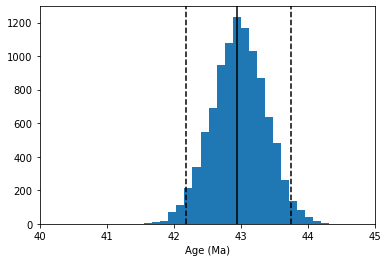

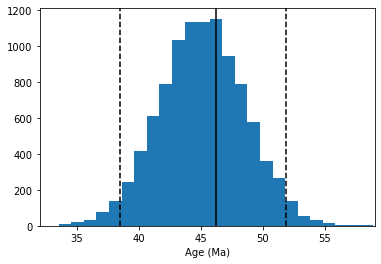

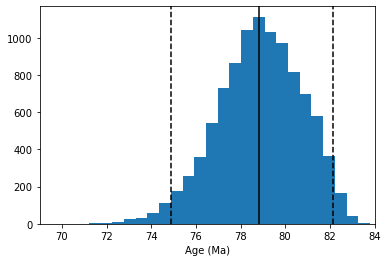

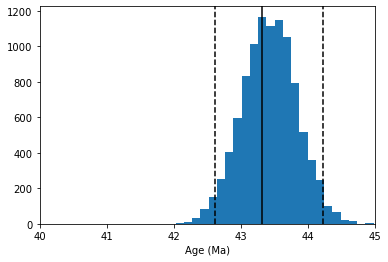

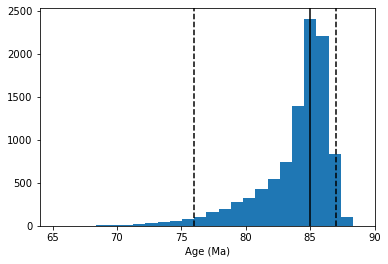

In [119]:
def YDZ(ages, errors, iterations=10000, chartOutput = False, bins=25):
    from scipy import stats
    """"

    NOTE: I Have not been able to reproduce Isoplot YDZ results using this adaptation - see Appendix B of Sharman and Malkowski (Earth-Science Reviews)

    Calculate the youngest detrital zircon age based on the Monte Carlo approach of IsoPlot (Ludwig, 2012). The youngest analyses (i.e., within 5 sigma of the youngest analysis) are repeatedly resampled by a probability distribution defined by their age and uncertainty.
    
    The YDZ is defined as the mode of the resulting distribution of ages and the uncertainty is reported as the P2.5 and P97.5. The resulting range accounts for 95% of the total range in values.
    Note that the age mode is defined as the midpoint of the histogram bin with the highest value (following IsoPlot). The mode is thus not independent of the choice of how many bins to define.
    
    Paramters
    ---------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    iterations : (optional) the number of Monte Carlo iterations performed (default = 10000)
    chartOutput : (optional) returns a figure showing the montecarlo distribution
    bins : (optional) the number of bins to use in the histogram

    Returns
    -------
    YDZ : [the mode of youngest ages, the positive error (2-sigma), and the negative error (2-sigma)] Note that the error distribution is not symmetrical because it is based on the P2.5 and P97.5 of the distribution
    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    YDZ = []

    for i in range(len(ages)):

        data_err1s = list(zip(ages[i], errors[i]))
        
        # Identify the youngest analysis
        YSG_age, YSG_err1s = YSG(ages[i], errors[i])[0]

        ageCutoff = YSG_age + YSG_err1s*5 # 5 for 5-sigma

        # Identify all analyses within 5 sigma of the youngest analysis
        data_err1s.sort(key=lambda d: d[0]) # Sort based on age
        filtered = list(filter(lambda x: x[0] < ageCutoff, data_err1s)) # Filter out ages too old

        minAges = []
        for i in range(iterations):
            newAge_Ma = []
            for analysis in filtered:
                newAge_Ma.append(np.random.normal(loc = analysis[0], scale=analysis[1]))
            minAges.append(min(newAge_Ma))
    
        # Find the mode of the minimum ages
        binIndex, binAge = np.histogram(minAges, bins=bins)
        binMaxIndex = np.argmax(binIndex)
        binMaxAge = binAge[binMaxIndex]
        mode = binMaxAge + (binAge[binMaxIndex+1] - binMaxAge)/2

        YDZ.append([mode, np.percentile(minAges, 97.5)-mode, mode-np.percentile(minAges, 2.5)])

        if chartOutput:
            #KDE_age, KDE = dFunc.KDEcalcAges_2([minAges], bw=1, xdif=0.1)
            fig, ax = plt.subplots(1)
            ax.set_xlim(int(min(minAges))-1,int(max(minAges))+1,0.5)
            #ax.plot(KDE_age, KDE[0])
            ax.hist(minAges, bins=bins)
            ax.axvline(mode,color='black')
            ax.axvline(np.percentile(minAges,2.5),linestyle='--',color='black')
            ax.axvline(np.percentile(minAges,97.5),linestyle='--',color='black')
            ax.set_xlabel('Age (Ma)')

    return YDZ


YDZ(ages, errors, iterations=10000, chartOutput = True, bins=25)

In [88]:
YDZ1 = YDZ(ages, errors)
YDZ_Table = pd.DataFrame(data=YDZ1, index=[sample_list], columns=['WM', '+2sError', '-2sError'])
print(YDZ_Table)

              WM   +2sError   -2sError
POR-2  42.922529   1.628608   1.535153
POR-3  44.983773  13.460219  13.453404
BUT-5  77.790502   4.952229   8.422130
POR-1  43.645401   1.415980   1.741661
BUT-4  82.861233   3.354276  25.193546


### 6. Y3Zo: Youngest Three Zircons (Y3Zo) 
Calculating a MDA from the weighted average of the youngest three zircons is achieved by the weighted average of the youngest three zircon dates that overlap within uncertainty (generally 2s) (e.g., Ross et al., 2017). The selection of three dates used in the Y3Zo should follow the same criteria as the YGC 2s method, however only the youngest three overlapping dates should be averaged. The uncertainty of the MDA calculated by these methods is the uncertainty of the weighted average.

In [95]:
def Y3Zo(ages, errors, sigma=2):
    """
    Calculates the weighted mean average of the youngest three zircons that overlap within uncertainty of sigma (default is 2-sigma) (see discussion in Coutts et al. (2019): Geoscience Frontiers)

    Parameters
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    sigma : (optional) level of uncertainty to evaluate overlap (default is 2-sigma)

    Returns
    -------
    Y3Zo : [the weighted mean age, the 2-sigma uncertainty, and the MSWD]

    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    Y3Zo = []

    for i in range(len(ages)):

        if sigma == 1:
            data_err = list(zip(ages[i], errors[i]))
            data_err.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 1s error     
        if sigma == 2:
            data_err = list(zip(ages[i], errors[i]*2))
            data_err.sort(key=lambda d: d[0] + d[1]) # Sort based on age + 2s error

        Y3Zo_cluster, Y3Zo_imax = find_youngest_cluster(data_err, 3)
        if sigma == 1:
            Y3Zo_WM, Y3Zo_WM_err2s, Y3Zo_WM_MSWD = weightedMean(np.array([d[0] for d in Y3Zo_cluster[:3]]), np.array([d[1] for d in Y3Zo_cluster[:3]]))
        if sigma == 2:
            Y3Zo_WM, Y3Zo_WM_err2s, Y3Zo_WM_MSWD = weightedMean(np.array([d[0] for d in Y3Zo_cluster[:3]]), np.array([d[1]/2 for d in Y3Zo_cluster[:3]]))
        
        # Return NaN if Y3Zo did not find a cluster
        if Y3Zo_WM == 0.0:
            Y3Zo.append([np.nan,np.nan,np.nan])
        else:
            Y3Zo.append([Y3Zo_WM, Y3Zo_WM_err2s, Y3Zo_WM_MSWD])

    return Y3Zo

Y3Zo(ages, errors, sigma=2)

[[49.02852625118508, 0.6549617480148279, 0.36343327333782127],
 [87.19636511806033, 2.1073847249994846, 0.33159156620794694],
 [84.34269377110553, 1.878703267619104, 3.1282575789964113],
 [88.55868674367412, 1.7307221861663795, 1.064180175897142],
 [87.62024157875872, 2.639129652295718, 0.8863052211799931]]

In [96]:
Y3Zo1 = Y3Zo(ages, errors)
Y3Zo_Table = pd.DataFrame(data=Y3Zo1, index=[sample_list], columns=['WM', 'Error', 'MSWD'])
print(Y3Zo_Table)

              WM     Error      MSWD
POR-2  49.028526  0.654962  0.363433
POR-3  87.196365  2.107385  0.331592
BUT-5  84.342694  1.878703  3.128258
POR-1  88.558687  1.730722  1.064180
BUT-4  87.620242  2.639130  0.886305


### 7. Y3Za: Youngest Three Zircons (Y3Za) 
Calculating a MDA from the weighted average of the youngest three zircons present in the sample (e.g., Zhang et al., 2016). The uncertainty of the MDA calculated by these methods is the uncertainty of the weighted average.

In [93]:
def Y3Za(ages, errors):
    """
    Calculates the weighted mean average of the youngest three zircons, regardless of whether they overlap within error (see discussion in Coutts et al. (2019): Geoscience Frontiers)

    Parameters
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups

    Returns
    -------
    Y3Za : [the weighted mean age, the 2-sigma uncertainty, and the MSWD]

    """

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    Y3Za = []

    for i in range(len(ages)):
        data_err1s_ageSort = (list(zip(ages[i], errors[i])))
        data_err1s_ageSort.sort(key=lambda d: d[0]) # Sort based on age
        Y3Za_WM, Y3Za_WMerr2s, Y3Za_WM_MSWD = weightedMean([x[0] for x in data_err1s_ageSort[:3]], [x[1] for x in data_err1s_ageSort[:3]])
        if len(ages[i]) < 3: # Return nulls if the samples has less than 3 analyses
            Y3Za.append([np.nan,np.nan,np.nan])
        else:
            Y3Za.append([Y3Za_WM, Y3Za_WMerr2s, Y3Za_WM_MSWD])

    return Y3Za

Y3Za(ages, errors)



[[45.83175329604755, 0.8839789923692695, 10.165357162840799],
 [84.48397901282813, 2.9501827234390383, 17.288675463406165],
 [82.01924985208007, 2.51210789255235, 0.15540703492856328],
 [45.64083656111823, 1.5438081856676846, 68.11072376402986],
 [86.34611061604616, 3.2473809078643074, 0.046819007189667916]]

In [94]:
Y3Za1 = Y3Za(ages, errors)
Y3Za_Table = pd.DataFrame(data=Y3Za1, index=[sample_list], columns=['WM', 'Error', 'MSWD'])
print(Y3Za_Table)

              WM     Error       MSWD
POR-2  45.831753  0.883979  10.165357
POR-3  84.483979  2.950183  17.288675
BUT-5  82.019250  2.512108   0.155407
POR-1  45.640837  1.543808  68.110724
BUT-4  86.346111  3.247381   0.046819


### 8. t Method 
The t method of Barbeau et al. (2009) calculates the weighted average, weighed by date uncertainty, of all dates that fall between the probability minima of the youngest peak composed of a specified number of grains on a probability density function. The number of dates required for a peak to be considered significant varies between studies. In this model we used a minimum of three dates. The uncertainty of the MDA is the uncertainty of the weighted average.

In [89]:

def tauMethod(ages, errors, min_cluster_size=3, thres=0.01, minDist=1, xdif=1, chartOutput = False, x1=0, x2=4000):
    """
    Calculates the tau parameter, which is the mean weighted average of analyses that fall between probability minima (troughs) of a PDP plot (after Barbeau et al. (2009): EPSL)

    Parameters
    ----------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    min_cluster_size : (optional) the minimum number of analyses to calculate mean weighted average (default = 3)
    thres : (optional) threshold of what constitues a peak (from 0 to 1). Default = 0.01
    minDist : (optional) minimum distance (Myr) between adjacent peaks. Default = 1
    xdif : (optional) bin size to compute PDP (default = 1 Ma)
    chartOutput : (optional) set to True to create plots
    x1 : (optional) minimum x-axis value (default = 0 Ma)
    x2 : (optional) maximum x-axis value (default = 4000 Ma)

    Returns
    -------
    tauMethod : [the weighted mean age in Ma, the 2-sigma uncertainty of the weighted mean age, the MSWD of the weighted mean age, and the number of analyses included in the weighted mean age]

    """

    import peakutils

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]

    # Calculate the PDP - note that a small xdif may be desired for increased precision
    PDP_age, PDP = PDPcalcAges(ages, errors, xdif)

    tauMethod = []
    for i in range(len(ages)):  

        # Calculate peak indexes
        peakIndexes = list(peakutils.indexes(PDP[i], thres=thres, min_dist=minDist))
        # Peak ages
        peakAges = PDP_age[peakIndexes]
        # Number of grains per peak
        peakAgeGrain = peakAgesGrains([peakAges], [ages[i]], [errors[i]])[0]

        # Calculate trough indexes
        troughIndexes = list(peakutils.indexes(PDP[i]*-1, thres=thres, min_dist=minDist))
        # Trough ages
        troughAges = [0] + list(PDP_age[troughIndexes]) + [4500] # Append a 0 because there is no trough on the young size of the youngest peak and no trough on the old side of the oldest peak

        # Zip peak ages and grains per peak
        peakAgesGrains_ = list(zip(peakAges, peakAgeGrain))
        # Filter out peaks with less than min_cluster_size grains (default is 3, following Barbeau et al., 2009: EPSL)
        peakAgesGrainsFiltered = list(filter(lambda x: x[1] >= min_cluster_size, peakAgesGrains_))

        # Stop the loop if no peaks are present with the min_cluster_size
        if peakAgesGrainsFiltered == []:
            tauMethod.append([np.nan, np.nan, np.nan, np.nan])
            continue

        # Select the nearest trough that is younger than the youngest peak with at least min_cluster_size analyses
        troughYoung = np.max(list(filter(lambda x: x < peakAgesGrainsFiltered[0][0], troughAges)))

        # Select the nearest trough that is older than the youngest peak with at least min_cluster_size analyses
        troughOld = np.min(list(filter(lambda x: x > peakAgesGrainsFiltered[0][0], troughAges)))

        # Select ages and errors that fall between troughYoung and troughOld
        ages_errors1s = list(zip(ages[i], errors[i]))
        ages_errors1s_filtered = list(filter(lambda x: x[0] < troughOld and x[0] > troughYoung, ages_errors1s))

        tauMethod_WM, tauMethod_WM_err2s, tauMethod_WM_MSWD = weightedMean(np.array([d[0] for d in ages_errors1s_filtered]), np.array([d[1] for d in ages_errors1s_filtered]))

        tauMethod.append([tauMethod_WM, tauMethod_WM_err2s, tauMethod_WM_MSWD, len(ages_errors1s_filtered)])

        if chartOutput:
            fig, ax = plt.subplots(1)
            # Creates a plot output to check results
            ax.plot(PDP_age, PDP[i])
            ax.plot(PDP_age[peakIndexes], PDP[i][peakIndexes],'o')
            ax.plot(PDP_age[troughIndexes], PDP[i][troughIndexes],'o')
            ax.plot(tauMethod_WM,0,'s')
            ax.plot(ages_errors1s_filtered,np.zeros_like(ages_errors1s_filtered),'s')
            #ax.plot(tauMethod_WM-tauMethod_WM_err2s,0,'s')     
            ax.set_xlim(0,300)

    return tauMethod

tauMethod(ages, errors, min_cluster_size=3, thres=0.01, minDist=1, xdif=1, chartOutput = False, x1=0, x2=4000)

[[48.73244647509496, 0.5327683519754439, 2.897368501908655, 7],
 [92.67830422066368, 0.6294275308100156, 2.15843652986296, 39],
 [82.01924985208007, 2.51210789255235, 0.15540703492856328, 3],
 [95.59993199634452, 0.6503635895611289, 5.002693366643346, 60],
 [94.83659959554284, 1.371097103407156, 3.625433498519378, 23]]

In [90]:
Tau = tauMethod(ages, errors)
Tau_Table = pd.DataFrame(data=Tau, index=[sample_list], columns=['WM', 'Error', 'MSWD','Grains'])
print(Tau_Table)

              WM     Error      MSWD  Grains
POR-2  48.732446  0.532768  2.897369       7
POR-3  92.678304  0.629428  2.158437      39
BUT-5  82.019250  2.512108  0.155407       3
POR-1  95.599932  0.650364  5.002693      60
BUT-4  94.836600  1.371097  3.625433      23


### 9. YSP: The Youngest Statistical Population
Introduced and tested in Coutts et al 2019. The YSP method calculates the MDA as the weighted average of the youngest sub-sample of 2 or more grains that yield a mean square weighted deviation (MSWD) of w1, indicating that the dispersion in the dates is proportional to the uncertainty of the measurements (Wendt and Carl, 1991). To identify the sub-sample of dates used, the MSWD of the youngest two grains is calculated. If acceptable (i.e., <1), an additional grain or additional grains are added until the calculated MSWD exceeds 1. The weighted average of the sub-sample yielding an MSWD closest to 1 is used as the MDA. The uncertainty of the MDA is the uncer- tainty of the weighted average.

In [91]:
def YSP(ages, errors, min_cluster_size=2, MSWD_threshold=1):
    """
    Calculates the youngest statistical population after Coutts et al. (2019): Geoscience Frontiers. The YSP is the weighted average of the youngest group of 2 or more analyses that have a MSWD close to the MSWD_threshold (default=1),
    where the the MSWD of the youngest two analyses is less than the MSWD_threshold. The algorithm first considers the youngest two analyses. If they have an MSWD < 1, then a third grain is added and so forth.
    The final analyses to be included in the weighted average is the one with the closest value to MSWD_threshold (default of 1).

    Parameters
    ----------
    ages : a 2-D array of ages, len(ages)=number of samples or sample groups
    errors : a 2-D array of 1-sigma errors for each sample or sample group, len(errors)=number of samples or sample groups
    min_cluster_size : (optional) the minimum number of analyses to calculate a MSWD from (default = 2)
    MSWD_threshold : (optional) the MSWD threshold from which to select analyses from

    Returns
    -------
    YSP : [the weighted mean age in Ma, the 2-sigma uncertainty of the weighted mean age, the MSWD of the weighted mean age, and the number of analyses included in the weighted mean age]

    """ 

    # Check to see if ages is a list of arrays or just a single list of ages
    if not hasattr(ages[0], '__len__'):
        ages = [ages]
        errors = [errors]   

    YSP = []
    for i in range(len(ages)): # One loop for each sample or sample group
        
        # Zip ages and errors and sort by age
        data_err1s_ageSort = list(zip(ages[i], errors[i]))
        data_err1s_ageSort.sort(key=lambda d: d[0]) # Sort based on age
        for j in range(len(data_err1s_ageSort)): # One loop for each analysis. Loop repeated if MSWD of the first pair is not <1.

            # Creat list of MSWD
            MSWD = []
            for k in range(len(data_err1s_ageSort)):
                MSWD.append(weightedMean(np.array([d[0] for d in data_err1s_ageSort[:(k+2)]]), np.array([d[1] for d in data_err1s_ageSort[:(k+2)]]))[2])

            # Add MSWD to the ages & errors tuple   
            data_err1s_MSWD = []
            for k in range(len(data_err1s_ageSort)):
                if k == 0: # Assign the first age an MSWD of 0 (so it is always included in the MSWD)
                    data_err1s_MSWD.append((data_err1s_ageSort[k][0], data_err1s_ageSort[k][1], 0))
                else: # Assign analyses the MSWD of the previos analysis, such that the filtering returns the correct analyses
                    data_err1s_MSWD.append((data_err1s_ageSort[k][0], data_err1s_ageSort[k][1], MSWD[k-1]))

            # Need to exit the algorithm if no YSP is found
            if j == len(ages[i])-1:
                YSP.append([float('nan'), float('nan'), float('nan'), float('nan')])
                break

            # Find the index of the analysis with an MSWD closest to 1
            idx = (np.abs(np.array([d[2] for d in data_err1s_MSWD][1:])-MSWD_threshold)).argmin()+1 # Need to add 1 because we excluded the first one that had an assigned MSWD of 0

            # Filter analyses beyond the one which has a MSWD closest to MSWD_threshold
            agesFiltered = data_err1s_MSWD[0:idx+1]

            YSP_WM, YSP_WM_err2s, YSP_WM_MSWD = weightedMean(np.array([d[0] for d in agesFiltered]), np.array([d[1] for d in agesFiltered]))

            if (agesFiltered[1][2] < 1 and len(agesFiltered) >= min_cluster_size): # The first one is excluded because the MSWD is made to be 0. The second youngest analysis must have a MSWD < 1 to proceed. The minimum cluster size must also be met or exceeded.
                YSP.append([YSP_WM, YSP_WM_err2s, YSP_WM_MSWD, len(agesFiltered)])
                break
            else:
                del data_err1s_ageSort[0] # Delete the first analysis, which was no use at all, and try again

    return YSP

YSP(ages, errors)

[[49.15896935635634, 0.5862219049662019, 1.1401152724294132, 6],
 [90.30931956271935, 0.9117992702772999, 0.9963185433733495, 15],
 [84.26514776744625, 1.8192003570496884, 1.7021448470119438, 5],
 [91.3651331934338, 0.8898229017017832, 1.0269688733651399, 24],
 [90.77451736201486, 1.7420763222658622, 1.0412324344222736, 15]]

In [92]:
YSP = YSP(ages, errors)
YSP_Table = pd.DataFrame(data=YSP, index=[sample_list], columns=['WM', 'Error', 'MSWD','Grains'])
print(YSP_Table)


              WM     Error      MSWD  Grains
POR-2  49.158969  0.586222  1.140115       6
POR-3  90.309320  0.911799  0.996319      15
BUT-5  84.265148  1.819200  1.702145       5
POR-1  91.365133  0.889823  1.026969      24
BUT-4  90.774517  1.742076  1.041232      15


### 10. Vermeesh's Method

In [125]:
install.packages('IsoplotR')

NameError: name 'install' is not defined

### 11. TuffZirc 6+ in Isoplot
The TuffZirc algorithm of Ludwig and Mundil (2002) was originally designed to determine the age of ash de- posits and was designed for an input of 12e20 dates (Ludwig and Mundil, 2002). The algorithm has been used to calculate MDAs by inputting the youngest six dates obtained from a sample (Tucker et al., 2013) and is referred to as TuffZirc 6þ. The TuffZirc algorithm first screens the data for “high uncertainty dates”, which may skew the calculation. Then the largest sub-sample of dates that yields a probability-of-fit >0.05 is found (Ludwig and Mundil, 2002). A probability-of-fit >0.05 stipulates that input dates meet the minimum criteria to be derived from a parent population of a single age (within 95% confidence interval) and are dispersed only due to measurement uncertainty (Wendt and Carl, 1991). The al- gorithm then finds the median age of this sub-sample of dates, which is taken as the MDA. The MDA uncertainty is derived from the asymmetric distribution of dates (Ludwig and Mundil, 2002).

### AgePick 
AgePick is a Microsoft Excel!-based application for the interrogation of detrital zircon data. It is used to identify peaks in detrital zircon spectra and to qualitatively screen datasets for inheritance and lead loss (Gehrels, 2003). AgePick does not offer any built-in date-selection criteria for the calculation of MDAs. For the calculation of MDAs, it is typically used to compute the weighted averages of selected dates, or to identify the age of the youngest peak on a probability density plot (i.e., YPP method). While the criteria used to select dates for calculation of weighted averages through AgePick should be stated (e.g., Dickinson and Gehrels, 2009b; Tucker et al., 2013), thorough descriptions of grain-selection criteria are frequently missing in publications. AgePick should not be cited as the MDA calculation method and rather the method of date-selection (e.g., YGC 1s, Y3Z) should be specified.